In [1]:
# step 1. Import the necessary packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import zscore

# step 2. Downloading the California Housing dataset
from sklearn.datasets import fetch_california_housing

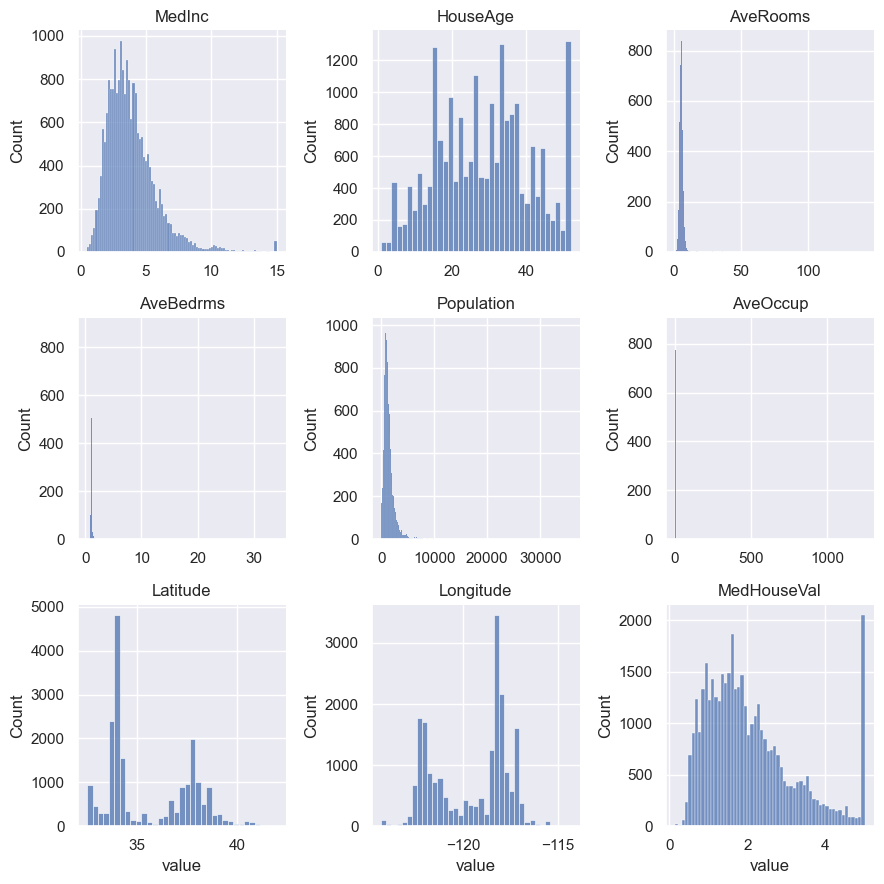

In [2]:
# step 2. Data review
california = fetch_california_housing(as_frame=True)
df_basic = california.frame

# Define the target variable
#target = df_basic.pop('MedHouseVal')

# Check for data types and missing values
#df_basic.info()

# Distribution of features
sns.set_theme()
melted = pd.concat([df_basic, df_basic['MedHouseVal']], axis=1).melt()
g = sns.FacetGrid(melted, col='variable', col_wrap=3, sharex=False, sharey=False)
g.map(sns.histplot, 'value') 
g.set_titles(col_template='{col_name}')
g.tight_layout()

In [3]:
# step 3. Additional data processing

In [4]:
# step 3.1. Purification of emissions for speakers:
 # AveRooms, AveBedrms, AveOccup and Population

# We will save the columns that we will clean from emissions in the array
columns_to_clean = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']

# We will select data only for the specified columns and apply the zscore function.
# Let's take its absolute value to take into account positive and negative deviations.
z_scores = np.abs(df_basic[columns_to_clean].apply(zscore))

# About 99.7% of values ​​are within three standard deviations (Z-score between -3 and 3).
# Therefore, we check if the Z-score is greater than 3. If so, then this value is considered an outlier/anomaly.
anomalies = (z_scores > 3)

# Let's use the any() method to find and delete all lines where there is at least one anomaly.
# So, let's leave only those rows where there are no anomalous values, using the inverted mask ~anomalies.any(axis=1).
# When inverting, the Boolean result changes False — an outlier, True — no.
df_cleaned = df_basic[~anomalies.any(axis=1)]

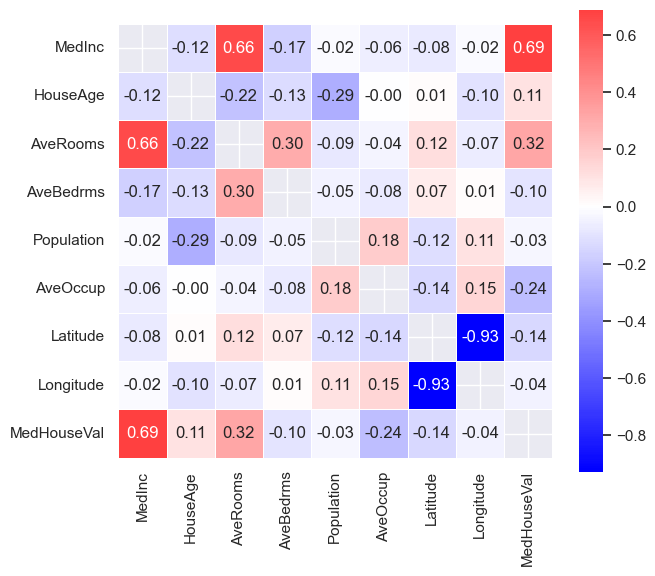

In [5]:
# step 3.2. Removal from the data set of one feature from those that have a high correlation with each other
corr_mtx = df_cleaned.corr()
mask_mtx = np.zeros_like(corr_mtx)
np.fill_diagonal(mask_mtx, 1)
fig, ax = plt.subplots(figsize=(7, 6))

# We calculate and visualize the correlation matrix
sns.heatmap(corr_mtx, cmap='bwr', center=0, annot=True, fmt='.2f', linewidth=0.5, square=True, mask=mask_mtx, ax=ax)
plt.show()

Select and remove one of the highly correlated features.

Please note that deleting: MedInc, HouseAge, AveRooms, Latitude, Longitude may lead to the loss of key information, which will worsen the quality of the model, as these features are important for the formation of housing prices.

### Reasoning for the importance of the features

- **MedInc**: Higher median income is often correlated with higher house prices, as people with higher incomes can afford more expensive houses.

- **HouseAge** and **AveRooms**: The age of a house and the number of rooms can also have a significant impact on its value. Newer homes and/or those with more rooms are usually more expensive due to more modern living conditions and lower maintenance costs.

- **Latitude** and **Longitude**: The location of the house is one of the most important factors. Areas closer to urban centres or in prestigious areas have higher house prices.

So, in our case, removal is advisable: AveBedrms or AveOccup

In [6]:
# Let's consider both cases
# Option 1
df_cleaned_AveBedrms = df_cleaned.drop(columns=['AveBedrms'])

In [7]:
# step 4. Splitting the input dataset into training and test samples
# Defining the features and the target variable

X1 = df_cleaned_AveBedrms.drop(columns='MedHouseVal')
y1 = df_cleaned_AveBedrms['MedHouseVal']

# Dividing data into training and test samples
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [8]:
# step 5. Features are normalised
scaler1 = StandardScaler().set_output(transform='pandas').fit(X_train1)
X_train_scaled1 = scaler1.transform(X_train1)
X_test_scaled1 = scaler1.transform(X_test1)

# Signs after normalisation
# print(X_train_scaled1.describe())

In [9]:
# step 6. Building the model
model1 = LinearRegression().fit(X_train_scaled1, y_train1) 
y_pred1 = model1.predict(X_test_scaled1) 
ymin1, ymax1 = y_train1.agg(['min', 'max']).values 
y_pred1 = pd.Series(y_pred1, index=X_test_scaled1.index).clip(ymin1, ymax1) 
# print(y_pred1.head())

In [10]:
# step 7. We evaluated the model's performance by such metrics as: R-squared, MAE, MAPE
r_sq1 = model1.score(X_train_scaled1, y_train1)
mae1 = mean_absolute_error(y_test1, y_pred1)
mape1 = mean_absolute_percentage_error(y_test1, y_pred1)
print("Evaluation of the accuracy of the base model (removal of the feature AveBedrms):")
print(f'R2: {r_sq1:.2f} | MAE: {mae1:.2f} | MAPE: {mape1:.2f}\n')

Evaluation of the accuracy of the base model (removal of the feature AveBedrms):
R2: 0.64 | MAE: 0.50 | MAPE: 0.29



In [11]:
# step 8. Comparing new metrics with model metrics
poly1 = PolynomialFeatures(2).set_output(transform='pandas')
Xtr1 = poly1.fit_transform(X_train_scaled1)
Xts1 = poly1.transform(X_test_scaled1)
model_upd1 = LinearRegression().fit(Xtr1, y_train1)
y_pred_upd1 = model_upd1.predict(Xts1)
y_pred_upd1 = pd.Series(y_pred_upd1, index=Xts1.index).clip(ymin1, ymax1)
r_sq_upd1 = model_upd1.score(Xtr1, y_train1)
mae_upd1 = mean_absolute_error(y_test1, y_pred_upd1)
mape_upd1 = mean_absolute_percentage_error(y_test1, y_pred_upd1)
print("Construction and evaluation of the accuracy of polynomial regression (in the variant with the removal of AveBedrms):")
print(f'R2: {r_sq_upd1:.2f} | MAE: {mae_upd1:.2f} | MAPE: {mape_upd1:.2f}')
print("---------------------------------------------------------------------------")

Construction and evaluation of the accuracy of polynomial regression (in the variant with the removal of AveBedrms):
R2: 0.70 | MAE: 0.45 | MAPE: 0.25
---------------------------------------------------------------------------


In [12]:
# Option 2
df_cleaned_AveOccup = df_cleaned.drop(columns=['AveOccup'])
X2 = df_cleaned_AveOccup.drop(columns='MedHouseVal')
y2 = df_cleaned_AveOccup['MedHouseVal']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

scaler2 = StandardScaler().set_output(transform='pandas').fit(X_train2)
X_train_scaled2 = scaler2.transform(X_train2)
X_test_scaled2 = scaler2.transform(X_test2)
# print(X_train_scaled2.describe())

model2 = LinearRegression().fit(X_train_scaled2, y_train2) 
y_pred2 = model2.predict(X_test_scaled2) 
ymin2, ymax2 = y_train2.agg(['min', 'max']).values 
y_pred2 = pd.Series(y_pred2, index=X_test_scaled2.index).clip(ymin2, ymax2)
# print(y_pred2.head())

r_sq2 = model2.score(X_train_scaled2, y_train2)
mae2 = mean_absolute_error(y_test2, y_pred2)
mape2 = mean_absolute_percentage_error(y_test2, y_pred2)
print("Evaluation of the accuracy of the base model (removal of the feature AveOccup):")
print(f'R2: {r_sq2:.2f} | MAE: {mae2:.2f} | MAPE: {mape2:.2f}\n')

poly2 = PolynomialFeatures(2).set_output(transform='pandas')
Xtr2 = poly2.fit_transform(X_train_scaled2)
Xts2 = poly2.transform(X_test_scaled2)
model_upd2 = LinearRegression().fit(Xtr2, y_train2)
y_pred_upd2 = model_upd2.predict(Xts2)
y_pred_upd2 = pd.Series(y_pred_upd2, index=Xts2.index).clip(ymin2, ymax2)
r_sq_upd2 = model_upd2.score(Xtr2, y_train2)
mae_upd2 = mean_absolute_error(y_test2, y_pred_upd2)
mape_upd2 = mean_absolute_percentage_error(y_test2, y_pred_upd2)
print("Construction and evaluation of the accuracy of polynomial regression (in the variant with the removal of AveOccup):")
print(f'R2: {r_sq_upd2:.2f} | MAE: {mae_upd2:.2f} | MAPE: {mape_upd2:.2f}')
print("---------------------------------------------------------------------------")

Evaluation of the accuracy of the base model (removal of the feature AveOccup):
R2: 0.61 | MAE: 0.52 | MAPE: 0.31

Construction and evaluation of the accuracy of polynomial regression (in the variant with the removal of AveOccup):
R2: 0.67 | MAE: 0.48 | MAPE: 0.27
---------------------------------------------------------------------------


# Conclusions.

Removing the AveBedrms feature from the model improved the accuracy of the predictions compared to the original model.


Estimation of the accuracy of the baseline model (removal of the AveBedrms feature):

R2: 0.64 | MAE: 0.50 | MAPE: 0.29


Building and evaluating the accuracy of polynomial regression:

R2: 0.70 | MAE: 0.45 | MAPE: 0.25


R2 - increased |MAE - decreased by 10% | MAPE - decreased by ~14%

the accuracy of the model reaches ((1 - MAPE) ⋅ 100) = ((1 - 0.25) ⋅ 100) = 75% 

A 10% reduction in MAE shows that the model has become more efficient in forecasting and better adapts to the data, resulting in reduced forecasting errors. 

********************************************************************

Removing the "AveOccup" feature from the model improved the accuracy of the predictions compared to the original model.


Estimation of the accuracy of the baseline model (removal of the AveOccup feature):

R2: 0.61 | MAE: 0.52 | MAPE: 0.31


Building and evaluating the accuracy of polynomial regression:

R2: 0.67 | MAE: 0.48 | MAPE: 0.27


R2 - increased |MAE - decreased by ~8% | MAPE - decreased by ~13%

model accuracy reaches ((1 - MAPE) ⋅ 100) = ((1 - 0.27) ⋅ 100) = 73% 

The decrease in MAE by ~8% shows that the model has become more efficient in forecasting and better adapts to the data, thus reducing forecasting errors. 

********************************************************************

These findings show that removing both features leads to an improvement in model accuracy, but removing "AveBedrms" has a greater positive effect on forecast accuracy.